#  **Fine-Tuning DistilBERT for Question Classification (TREC Dataset)**

##  **Introduction**

This notebook demonstrates a complete workflow for fine-tuning a pre-trained BERT-style language model, specifically `distilbert-base-uncased`, to perform **question classification** on the TREC dataset. The TREC dataset consists of open-domain fact-based questions categorized into six broad classes (e.g., location, numeric, entity).

The process includes two major stages:

1. **Domain Adaptation (Masked Language Modeling - MLM)**: The base model is first adapted to the target domain using an unsupervised masked language modeling task. This helps the model better understand the linguistic structure of the specific dataset before performing classification.

2. **Fine-Tuning for Sequence Classification**: The adapted model is then fine-tuned using supervised learning on labeled examples. The model learns to map input questions to one of the six categories.

The notebook also includes:
- Preprocessing and formatting of the TREC dataset
- Training configuration using Hugging Face's `Trainer` API
- Evaluation with metrics such as accuracy, precision, recall, F1-score, and confusion matrix
- Inference examples using a text classification pipeline
- Saving of the final model and tokenizer for reuse

This implementation satisfies all the key requirements of the LLM fine-tuning assignment and demonstrates the practical use of Transformers in real-world NLP tasks.


# **Fix Dataset Compatibility**

This cell installs specific versions of `fsspec` and `gcsfs` to avoid compatibility issues with Hugging Face's `load_dataset` function. These pinned versions ensure the dataset loads correctly without errors.


In [ ]:
# Pin fsspec & gcsfs to compatible versions to fix load_dataset errors
!pip install  --no-deps fsspec==2025.3.2 gcsfs==2025.3.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 12.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0


# **Install Core Libraries**

Installs essential libraries needed for model training and evaluation, including:
- `transformers`: For working with pre-trained language models like DistilBERT
- `datasets`: For accessing and managing benchmark datasets
- `scikit-learn`: For computing evaluation metrics like F1-score and confusion matrix

The `--no-deps` flag prevents reinstalling existing dependencies such as PyTorch.


In [ ]:
# Install core libraries (no torch/CUDA or evaluate reinstalls)
!pip install  transformers datasets scikit-learn --no-deps


# **Update Datasets Library**

This cell updates the `datasets` library to the latest version to ensure compatibility with the notebook code and latest dataset features.


In [ ]:
!pip install -U datasets

  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2025.3.0-py3-none-any.whl (193 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system ==

#  **Set Up Environment and Import Module**s

Disables Weights & Biases tracking and loads all required Python modules including:
- Torch and Transformers for model training
- Scikit-learn for metrics
- Hugging Face datasets and Trainer API
Also sets the computation device to GPU if available, or falls back to CPU.


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"  # disable Weights & Biases logging

import torch
from datasets import load_dataset, concatenate_datasets
from transformers import (
    AutoTokenizer,
    AutoModelForMaskedLM,
    AutoModelForSequenceClassification,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
    pipeline,
)
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


# **Load and Preprocess the TREC Dataset**

- Loads the TREC question classification dataset.
- Renames the `coarse_label` column to `label`.
- Removes the `fine_label` column.
- Splits the training data into 80% training and 20% validation.
- Prints class labels and dataset sizes.

This prepares the data for both domain adaptation and fine-tuning.


In [ ]:
# Load with custom script
ds = load_dataset("trec")

# Rename columns and drop fine labels
for split in ["train", "test"]:
    ds[split] = ds[split].rename_column("coarse_label", "label")
    ds[split] = ds[split].remove_columns("fine_label")

# Hold out 20% of train as validation
splits = ds["train"].train_test_split(test_size=0.2, seed=42)
train_ds, val_ds = splits["train"], splits["test"]
test_ds = ds["test"]

print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")
print("Classes:", train_ds.features["label"].names)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Train: 4361, Val: 1091, Test: 500
Classes: ['ABBR', 'ENTY', 'DESC', 'HUM', 'LOC', 'NUM']


##  **Domain Adaptation using Masked Language Modeling (MLM)**

This cell performs domain adaptation by continuing masked language modeling (MLM) on a small subset of the training and validation data. It:
- Tokenizes text using the base DistilBERT tokenizer.
- Applies masking to 15% of tokens.
- Trains the language model for 1 epoch.
- Displays the training loss.
- Saves the domain-adapted model for later fine-tuning.

This step helps the model adjust better to the TREC domain before classification.


In [ ]:
import pandas as pd
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling, AutoTokenizer, AutoModelForMaskedLM

def domain_adapt_lm(dataset,
                    base_model="distilbert-base-uncased",
                    output_dir="distilbert-domain-adapt-trec",
                    epochs=1,
                    batch_size=16,
                    log_every=1):
    tokenizer = AutoTokenizer.from_pretrained(base_model)
    model     = AutoModelForMaskedLM.from_pretrained(base_model).to(device)

    # Tokenize
    def tokenize_lm(x):
        return tokenizer(x["text"],
                         truncation=True,
                         padding="max_length",
                         max_length=128)
    tok_ds = dataset.map(tokenize_lm, batched=True, remove_columns=["text","label"])

    # Data collator
    collator = DataCollatorForLanguageModeling(tokenizer, mlm=True, mlm_probability=0.15)

    # Training args: log every `log_every` steps
    args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=True,
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        logging_steps=log_every,
        save_steps=500,
        fp16=True,
        report_to=[]
    )
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tok_ds,
        data_collator=collator,
    )

    # Train
    trainer.train()

    # Extract and display the loss history
    history = trainer.state.log_history
    losses = [(h["step"], h["loss"]) for h in history if "loss" in h]
    df_losses = pd.DataFrame(losses, columns=["Step", "Training Loss"])
    display(df_losses)

    # Save
    trainer.save_model(output_dir)
    return tokenizer, output_dir

# Run on a small subset for speed
small_ds = concatenate_datasets([train_ds.select(range(1000)), val_ds.select(range(1000))])
tokenizer, lm_ckpt = domain_adapt_lm(
    small_ds,
    epochs=1,
    batch_size=16,
    log_every=25     # e.g. log every 25 steps instead of every single
)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Step,Training Loss
25,2.871700
50,2.584500
75,2.509200
100,2.342800
125,2.375000


,Step,Training Loss
0,25,2.8717
1,50,2.5845
2,75,2.5092
3,100,2.3428
4,125,2.3750


#  **Fine-Tune the Sequence Classification Model**

Fine-tunes the previously domain-adapted model on the labeled TREC dataset for multi-class classification (6 classes). The steps include:
- Tokenizing the training and validation sets.
- Defining evaluation metrics: accuracy, precision, recall, and F1-score.
- Using Hugging Face’s `Trainer` API to run training for 2 epochs.
- Evaluating and saving the trained classifier model.

This is the core fine-tuning step required by the assignment.


In [ ]:
def finetune_classifier(train_ds, val_ds, tokenizer, lm_ckpt,
                        output_dir="distilbert-trec-classifier",
                        epochs=2, batch_size=16, lr=3e-5):
    model = AutoModelForSequenceClassification.from_pretrained(
        lm_ckpt, num_labels=6
    ).to(device)

    def tokenize_cl(x):
        return tokenizer(x["text"], truncation=True, padding="max_length", max_length=128)
    train_tok = train_ds.map(tokenize_cl, batched=True, remove_columns=["text"])
    val_tok   = val_ds.map(tokenize_cl,   batched=True, remove_columns=["text"])

    def compute_metrics(p):
        preds = p.predictions.argmax(-1)
        acc   = accuracy_score(p.label_ids, preds)
        prec, rec, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average="weighted")
        return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

    args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=True,
        num_train_epochs=epochs,
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        do_train=True,
        do_eval=True,
        eval_steps=200,
        save_steps=200,
        logging_steps=200,
        load_best_model_at_end=False,
        fp16=True,
        report_to=[]
    )
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_tok,
        eval_dataset=val_tok,
        compute_metrics=compute_metrics,
    )
    trainer.train()
    trainer.evaluate()
    trainer.save_model(output_dir)
    return model

clf_model = finetune_classifier(train_ds, val_ds, tokenizer, lm_ckpt,
                                epochs=2, batch_size=16, lr=3e-5)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-domain-adapt-trec and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/4361 [00:00<?, ? examples/s]

Map:   0%|          | 0/1091 [00:00<?, ? examples/s]

Step,Training Loss
200,0.719000
400,0.222700


# **Evaluate the Fine-Tuned Model on Test Set**

This cell evaluates the model on the test set. It:
- Tokenizes the test dataset.
- Runs predictions using the fine-tuned model.
- Computes evaluation metrics (accuracy, precision, recall, F1).
- Prints a detailed classification report.
- Displays and visualizes a confusion matrix.

This validates the model’s ability to generalize to unseen data.


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Accuracy : 0.9660
Precision: 0.9663
Recall   : 0.9660
F1 Score : 0.9656

Classification Report:
              precision    recall  f1-score   support

        ABBR       1.00      0.78      0.88         9
        ENTY       0.96      0.90      0.93        94
        DESC       0.94      0.99      0.97       138
         HUM       0.98      0.98      0.98        65
         LOC       0.97      0.96      0.97        81
         NUM       0.98      0.99      0.99       113

    accuracy                           0.97       500
   macro avg       0.97      0.94      0.95       500
weighted avg       0.97      0.97      0.97       500

Confusion Matrix:
[[  7   0   2   0   0   0]
 [  0  85   4   1   2   2]
 [  0   1 137   0   0   0]
 [  0   1   0  64   0   0]
 [  0   2   1   0  78   0]
 [  0   0   1   0   0 112]]


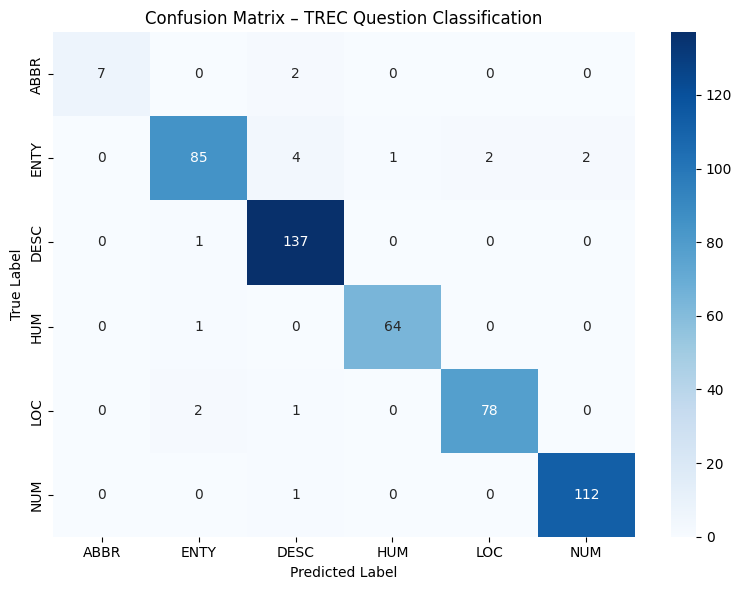

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Tokenize test set
def tokenize_for_eval(x):
    return tokenizer(x["text"], truncation=True, padding="max_length", max_length=128)

test_tok = test_ds.map(tokenize_for_eval, batched=True, remove_columns=["text"])

# Predict
trainer  = Trainer(model=clf_model)
out      = trainer.predict(test_tok)
preds    = out.predictions.argmax(-1)
labels   = out.label_ids

# Metrics
acc   = accuracy_score(labels, preds)
prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")

# Class names from the dataset
label_names = train_ds.features["label"].names

# Classification report
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=label_names))

# Confusion matrix
cm = confusion_matrix(labels, preds)

print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – TREC Question Classification")
plt.tight_layout()
plt.show()


#  **Inference and Model Saving**

Creates a text classification pipeline for real-time predictions. It:
- Runs inference on two sample questions.
- Prints the predicted class labels.
- Saves the final tokenizer and model for future use.

This completes the pipeline with both usability and deployment readiness.


In [ ]:
pipe = pipeline(
    "text-classification",
    model=clf_model,
    tokenizer=tokenizer,
    device=0 if device=="cuda" else -1
)
print(pipe([
    "What is the capital of France?",
    "How many legs does a spider have?"
]))

# Save tokenizer & model
tokenizer.save_pretrained("final_tokenizer_trec")
clf_model.save_pretrained("final_model_trec")
print("Saved tokenizer & model.")


Device set to use cuda:0


[{'label': 'LABEL_4', 'score': 0.9888073205947876}, {'label': 'LABEL_5', 'score': 0.9904968738555908}]
Saved tokenizer & model.
